# Rapidly-Exploring Random Tree (RRT)

Your task is to generate an RRT based on the following pseudocode:

```
def generate_RRT(x_init, num_vertices, dt):
    rrt = RRT(x_init)
    for k in range(num_vertices):
        x_rand = sample_state()
        x_near = nearest_neighbor(x_rand, rrt)
        u = select_input(x_rand, x_near)
        x_new = new_state(x_near, u, dt)
        # directed edge
        rrt.add_edge(x_near, x_new, u)
    return rrt
```
    
The `RRT` class has already been implemented. Your task is to complete the implementation of the following functions:

* `sample_state`
* `nearest_neighbor`
* `select_input`
* `new_state`


In [34]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import networkx as nx

%matplotlib inline 

In [35]:
plt.rcParams['figure.figsize'] = 12, 12

In [36]:
class RRT:
    def __init__(self, x_init):
        # A tree is a special case of a graph with
        # directed edges and only one path to any vertex.
        self.tree = nx.DiGraph()
        self.tree.add_node(x_init)
                
    def add_vertex(self, x_new):
        self.tree.add_node(tuple(x_init))
    
    def add_edge(self, x_near, x_new, u):
        self.tree.add_edge(tuple(x_near), tuple(x_new), orientation=u)
        
    @property
    def vertices(self):
        return self.tree.nodes()
    
    @property
    def edges(self):
        return self.tree.edges()
                                                  

In [37]:
def create_grid():
    grid = np.zeros((100, 100))
    # build some obstacles
    grid[10:20, 10:20] = 1
    grid[63:80, 10:20] = 1
    grid[43:60, 30:40] = 1
    grid[71:86, 38:50] = 1
    grid[10:20, 55:67] = 1
    grid[80:90, 80:90] = 1
    grid[75:90, 80:90] = 1
    grid[30:40, 60:82] = 1
    return grid

In [38]:
# environment encoded as a grid
grid = create_grid()

Let's take a look at the example environment we'll be using.

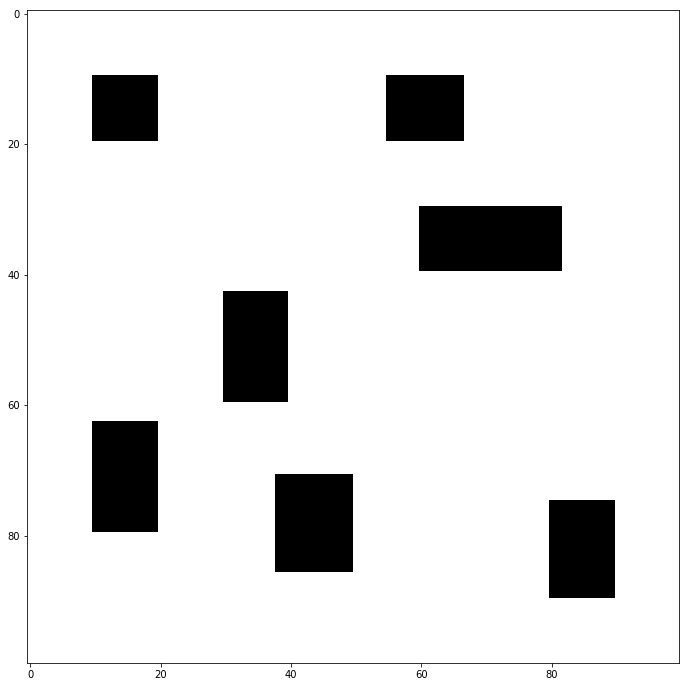

In [39]:
plt.imshow(grid, cmap='Greys', origin='upper')

Next you'll implement the functions necessary to generate an RRT. Feel free to change the function signatures however you please, just remember to update `generate_RRT` accordingly.

### Sampling States

The first part of generating an RRT is sampling states based on the environment. The sampled state must be in free space. 

In [40]:
x = np.random.uniform(0, grid.shape[0]-1)
y = np.random.uniform(0, grid.shape[1]-1)
(x, y)

(72.0211979793235, 9.339908896631119)

In [41]:
grid[3, 4]

0.0

In [42]:
grid

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [50]:
# state is not required to be free
# that test is done by caller
def sample_state(grid):
    x = np.random.uniform(0, grid.shape[0])
    y = np.random.uniform(0, grid.shape[1])    
    return (x, y)

### Nearest Neighbors

A critical part of the RRT procedure is finding the closest vertex to the sampled random point. This the most computationally intensive part so be mindful of that. Depending on the number of vertices a naive implementation will run into trouble quickly.

In [44]:
# NOTES:
# =====
# Called as the tree is being expanded. Since KDTree takes all the nodes
# as an argument upon creation, it seems like it cannot be used. Creating
# a new KDTree for each new vertex will be extremely wasteful.
#
# If RRT has a KDTree with amortized creation (that is, nodes can be added
# one by one), then that would be perfect. This would require a manual
# construction of a KDTree. Next time :D
#
# Since this is a Cartesian space, np.linalg.norm will do fine, but is still 
# O(n).
def nearest_neighbor(x_rand, rrt):
    # we don't have access to the grid, so start at a very large distance
    dist = 100000
    nearest_vertex = None
    x_rand = np.array(x_rand)
    
    for v in rrt.vertices:
        d = np.linalg.norm(x_rand - np.array(v[:2]))  # defaults to l2 norm
        if d < dist:
            dist = d
            nearest_vertex = v
    
    return nearest_vertex

### Selecting Inputs

Select input which moves `x_near` closer to `x_rand`. This should return the angle or orientation of the vehicle.

In [61]:
def select_input(x_rand, x_near):
    # this is like the "steering angle" of the car
    return np.arctan2(x_rand[1] - x_near[1], x_rand[0] - x_near[0])

# NOTE: A typo in return np.arctan2(x_rand[1] - x_near[1], x_rand[0] - x_near[0])
#       where the second argument was [x_rand[0] - x_near[0]], caused the
#       nx.tree.add_edge() to throw 'unhashable type' (vertices have to be
#       hashable)

Source code for [`networkx.classes.graph`](https://networkx.org/documentation/stable/_modules/networkx/classes/graph.html) has ample comments explaining the requirement for _hashable_ nodes.

### New State



The new vertex `x_new` is calculated by travelling from the current vertex `x_near` with a orientation `u` for time `dt`.

In [56]:
def new_state(x_near, u, dt):
    x_new = x_near[0] + np.cos(u) * dt
    y_new = x_near[1] + np.sin(u) * dt
    return (x_new, y_new)

In [57]:
tuple([2, 4])

(2, 4)

### Putting It All Together

Awesome! Now we'll put everything together and generate an RRT.

In [58]:
def generate_RRT(grid, x_init, num_vertices, dt):
    
    rrt = RRT(x_init)
    
    for _ in range(num_vertices):
        
        x_rand = sample_state(grid)
        # sample states until a free state is found
        while grid[int(x_rand[0]), int(x_rand[1])] == 1:
            x_rand = sample_state(grid)
            
        x_near = nearest_neighbor(x_rand, rrt)
        u = select_input(x_rand, x_near)
        x_new = new_state(x_near, u, dt)
            
        if grid[int(x_new[0]), int(x_new[1])] == 0:
            # the orientation `u` will be added as metadata to
            # the edge
            rrt.add_edge(x_near, x_new, u)
            
    return rrt

Feel free to change any of the values below.

In [59]:
num_vertices = 300
dt = 1
x_init = (50, 50)

rrt = generate_RRT(grid, x_init, num_vertices, dt)

Now let's plot the generated RRT.

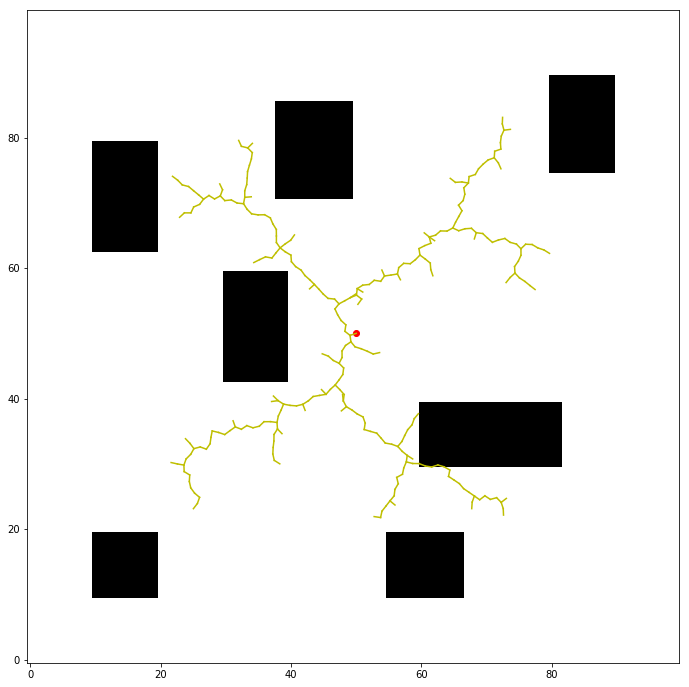

In [60]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(x_init[1], x_init[0], 'ro')

for (v1, v2) in rrt.edges:
    plt.plot([v1[1], v2[1]], [v1[0], v2[0]], 'y-')

plt.show()

[solution](/notebooks/RRT-Solution.ipynb)